In [2]:
!pip install optbinning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 5.26.1 which is incompatible.


In [3]:
import os, re, pickle, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from optbinning import OptimalBinning

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PROCESSED_DIR = "/content/drive/MyDrive/home_credit/processed"
OUTPUT_DIR = os.path.join(DATA_PROCESSED_DIR, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

POINTS0, ODDS0, PDO = 600, 11.5, 50

In [4]:
def gini_score(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1
def ks_statistic(y_true, y_pred):
    df = pd.DataFrame({"y": y_true, "score": y_pred}).sort_values("score")
    cum_good = (df["y"] == 0).cumsum() / (df["y"] == 0).sum()
    cum_bad = (df["y"] == 1).cumsum() / (df["y"] == 1).sum()
    return (cum_bad - cum_good).abs().max()

def proba_to_score(p, points0=POINTS0, odds0=ODDS0, pdo=PDO):
    p = np.clip(p, 1e-9, 1 - 1e-9)
    odds = p / (1 - p)
    factor = pdo / np.log(2)
    offset = points0 - factor * np.log(odds0)
    return offset - factor * np.log(odds)

In [5]:
X_train_fe = pd.read_parquet(os.path.join(DATA_PROCESSED_DIR, "X_train_fe.parquet"))
y_train = pd.read_parquet(os.path.join(DATA_PROCESSED_DIR, "y_train.parquet"))["TARGET"]
X_test_fe = pd.read_parquet(os.path.join(DATA_PROCESSED_DIR, "X_test_fe.parquet"))

train_ids = X_train_fe.pop("SK_ID_CURR") if "SK_ID_CURR" in X_train_fe.columns else None
test_ids = X_test_fe.pop("SK_ID_CURR") if "SK_ID_CURR" in X_test_fe.columns else None

print(f"Train shape: {X_train_fe.shape}, default rate: {y_train.mean():.2%}")
print(f"Test shape: {X_test_fe.shape}")

Train shape: (307511, 516), default rate: 8.07%
Test shape: (48744, 516)


In [6]:
candidates = [c for c in X_train_fe.columns if X_train_fe[c].nunique() > 1 and X_train_fe[c].isna().mean() <= 0.95]
df_full = X_train_fe[candidates].copy()
df_full["TARGET"] = y_train

df_dev, df_val = train_test_split(df_full, test_size=0.3, stratify=df_full["TARGET"], random_state=RANDOM_STATE)

print(f"Dev shape: {df_dev.shape}")
print(f"Val shape: {df_val.shape}")

Dev shape: (215257, 514)
Val shape: (92254, 514)


In [7]:
from optbinning import OptimalBinning

woe_results, iv_results = [], []

for feature in candidates:
    try:
        x, y = df_dev[feature].values, df_dev["TARGET"].values
        dtype = "categorical" if (df_dev[feature].dtype == "object" or df_dev[feature].nunique() < 10) else "numerical"
        optb = OptimalBinning(name=feature, dtype=dtype, solver="cp", max_n_bins=7, min_bin_size=0.05,
                              monotonic_trend="auto_asc_desc" if dtype == "numerical" else None)
        optb.fit(x, y)
        bt, iv = optb.binning_table.build(), optb.binning_table.iv

        woe_df = bt.copy()
        woe_df["Feature"] = feature
        woe_df["bin"] = woe_df.index.astype(str)
        col_map = {"Count": "total", "Event": "bad", "Non-event": "good", "WoE": "woe", "Event rate": "bad_rate", "Bin": "bin_range"}
        woe_df = woe_df.rename(columns=col_map)
        if "good" in woe_df.columns and "bad" in woe_df.columns:
            woe_df["dist_good"] = woe_df["good"] / woe_df["good"].sum()
            woe_df["dist_bad"] = woe_df["bad"] / woe_df["bad"].sum()
        woe_df = woe_df[woe_df["bin"] != "Totals"]
        if "bin_range" in woe_df.columns:
            woe_df = woe_df[~woe_df["bin_range"].astype(str).str.contains("Special|Missing", na=False)]

        woe_results.append(woe_df)
        iv_results.append({"Feature": feature, "IV": iv})
    except Exception as e:
        print(f"Skip {feature}: {e}")

all_woe_df = pd.concat(woe_results, ignore_index=True)
iv_df = pd.DataFrame(iv_results).sort_values("IV", ascending=False)
print(f"Đã binning xong {len(iv_df)} biến")
iv_df.head()

Đã binning xong 513 biến


,Feature,IV
135,ext_sources_mean,0.616632
136,ext_sources_sum,0.442103
40,EXT_SOURCE_3,0.331259
39,EXT_SOURCE_2,0.316959
138,ext_sources_weighted,0.184374


In [9]:
def apply_binning(df: pd.DataFrame, feature: str, woe_df: pd.DataFrame) -> pd.Series:
    feat_df = woe_df[woe_df["Feature"] == feature].copy()
    if feat_df.empty:
        raise ValueError(f"No binning info for feature={feature}")

    woe_s = pd.Series(index=df.index, dtype=float)

    for _, row in feat_df.iterrows():
        bin_range = str(row.get("bin_range", row["bin"]))
        woe_val = row["woe"]

        pattern = r"([[(])([-+0-9eEinf\.]+)\s*,\s*([-+0-9eEinf\.]+)([)\]])"
        m = re.match(pattern, bin_range)
        if not m:
            continue

        left_b, left_v, right_v, right_b = m.groups()
        left_incl, right_incl = left_b == "[", right_b == "]"
        left_v = float("-inf") if "inf" in left_v else float(left_v)
        right_v = float("inf") if "inf" in right_v else float(right_v)

        if left_incl and right_incl:
            mask = (df[feature] >= left_v) & (df[feature] <= right_v)
        elif left_incl:
            mask = (df[feature] >= left_v) & (df[feature] < right_v)
        elif right_incl:
            mask = (df[feature] > left_v) & (df[feature] <= right_v)
        else:
            mask = (df[feature] > left_v) & (df[feature] < right_v)

        woe_s[mask] = woe_val

    # Fill NaN bằng median WOE
    median_woe = feat_df["woe"].median()
    return woe_s.fillna(median_woe if not np.isnan(median_woe) else 0.0)

X_dev_woe = pd.DataFrame({f"{f}_woe": apply_binning(df_dev, f, all_woe_df) for f in candidates})
X_val_woe = pd.DataFrame({f"{f}_woe": apply_binning(df_val, f, all_woe_df) for f in candidates})
X_test_woe = pd.DataFrame({f"{f}_woe": apply_binning(X_test_fe, f, all_woe_df) for f in candidates})

woe_cols = [c for c in X_dev_woe.columns if c.endswith("_woe")]
X_dev_woe = X_dev_woe[woe_cols].fillna(0)
X_val_woe = X_val_woe[woe_cols].fillna(0)
X_test_woe = X_test_woe[woe_cols].fillna(0)

print(f"WOE features: {len(woe_cols)}")

WOE features: 513


In [10]:
sel = iv_df.query("IV >= 0.02 & IV <= 0.5")["Feature"].tolist()
if not sel:
    sel = iv_df.head(30)["Feature"].tolist()
sel_woe = [f"{f}_woe" for f in sel if f"{f}_woe" in woe_cols]
X_dev_sel = X_dev_woe[sel_woe]
X_val_sel = X_val_woe[sel_woe]
X_test_sel = X_test_woe[sel_woe]

print(f"Selected WOE features: {len(sel_woe)}")

Selected WOE features: 198


In [11]:
lr = LogisticRegression(max_iter=10000, class_weight="balanced", solver="lbfgs", C=1.0, n_jobs=-1)
lr.fit(X_dev_sel, df_dev["TARGET"])

dev_p = lr.predict_proba(X_dev_sel)[:, 1]
val_p = lr.predict_proba(X_val_sel)[:, 1]
test_p = lr.predict_proba(X_test_sel)[:, 1]

dev_auc = roc_auc_score(df_dev["TARGET"], dev_p)
val_auc = roc_auc_score(df_val["TARGET"], val_p)
dev_gini = gini_score(df_dev["TARGET"], dev_p)
val_gini = gini_score(df_val["TARGET"], val_p)
dev_ks = ks_statistic(df_dev["TARGET"], dev_p)
val_ks = ks_statistic(df_val["TARGET"], val_p)

print(f"Dev: AUC={dev_auc:.4f} Gini={dev_gini:.4f} KS={dev_ks:.4f}")
print(f"Val: AUC={val_auc:.4f} Gini={val_gini:.4f} KS={val_ks:.4f}")

Dev: AUC=0.7714 Gini=0.5428 KS=0.4084
Val: AUC=0.7679 Gini=0.5358 KS=0.4036


In [12]:
dev_score = proba_to_score(dev_p)
val_score = proba_to_score(val_p)
test_score = proba_to_score(test_p)

print(f"Dev score: [{dev_score.min():.0f}, {dev_score.max():.0f}]")
print(f"Val score: [{val_score.min():.0f}, {val_score.max():.0f}]")

Dev score: [117, 762]
Val score: [112, 721]


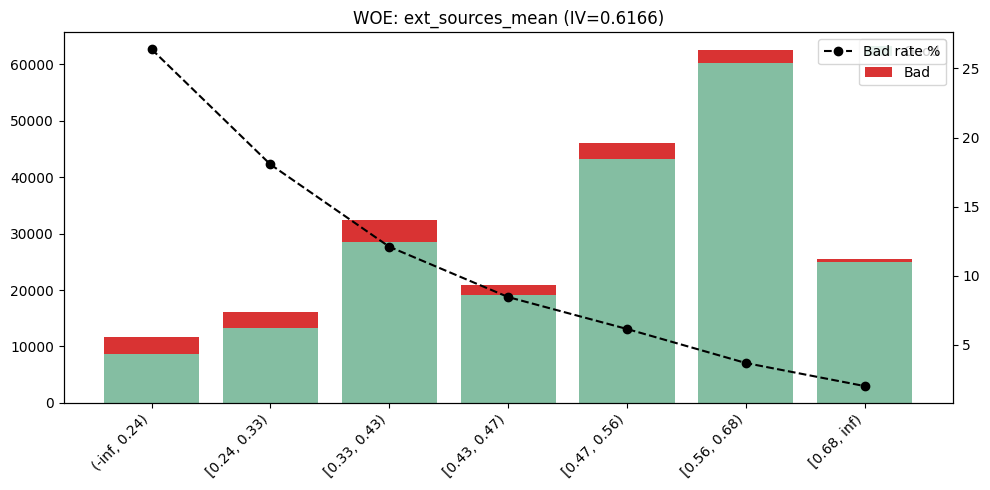

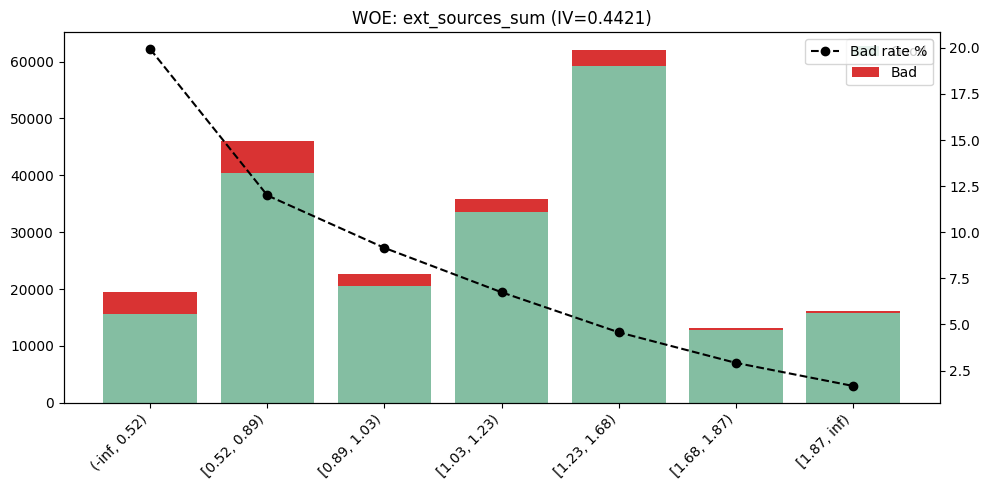

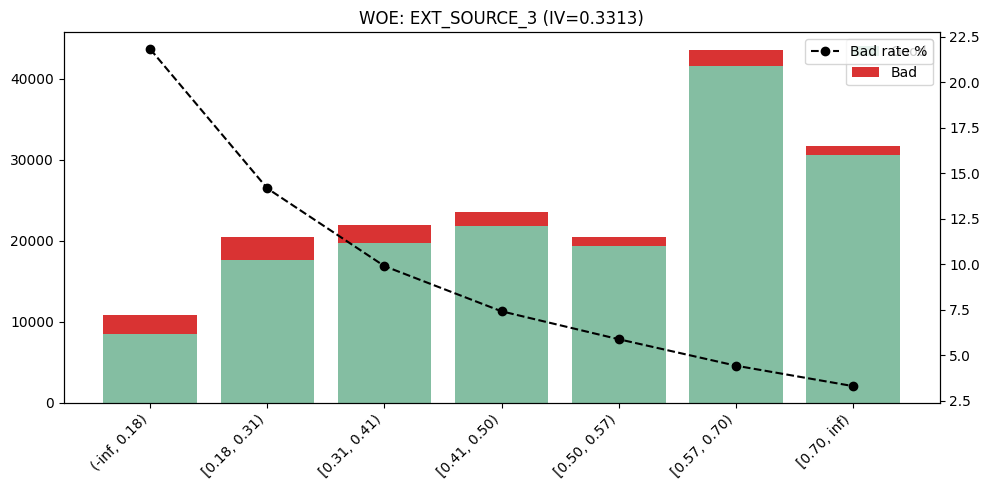

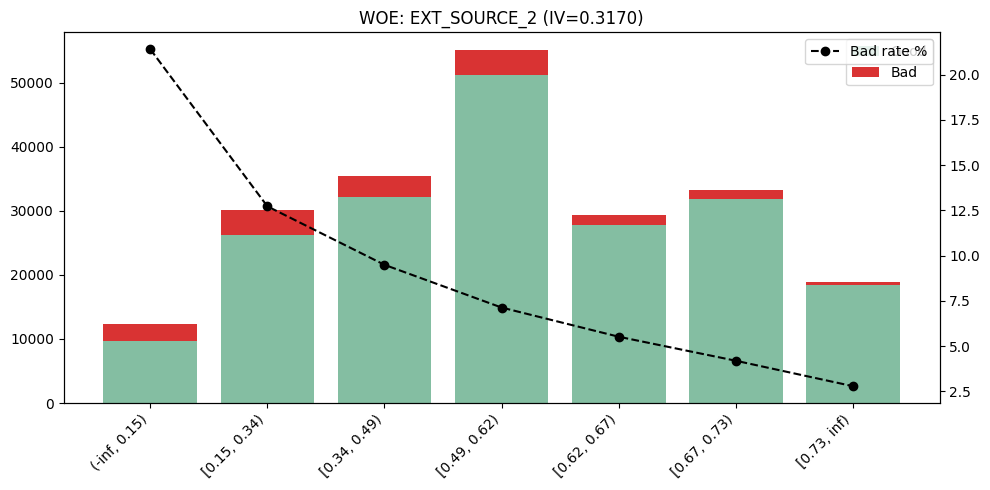

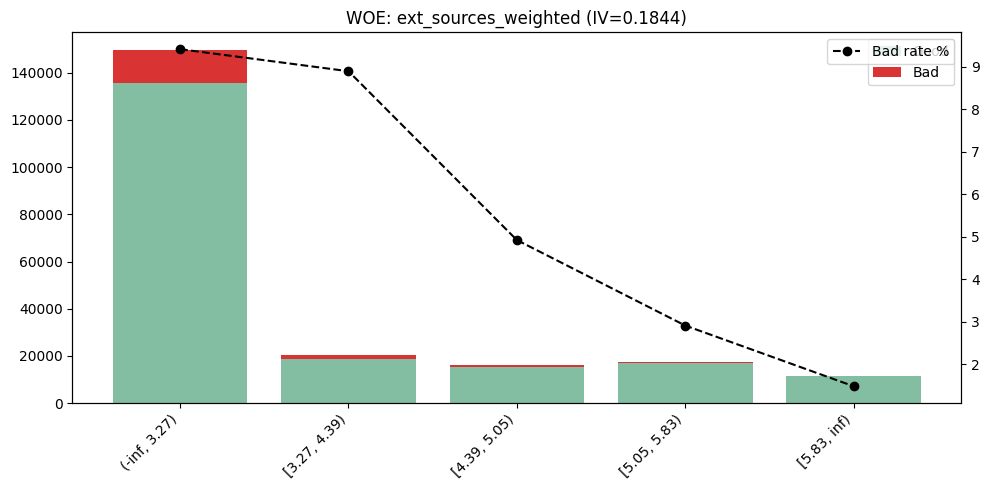

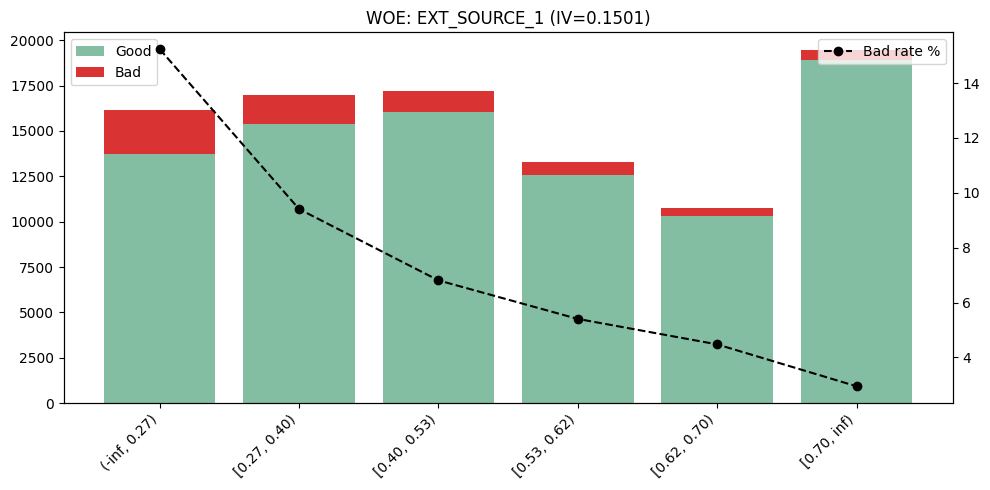

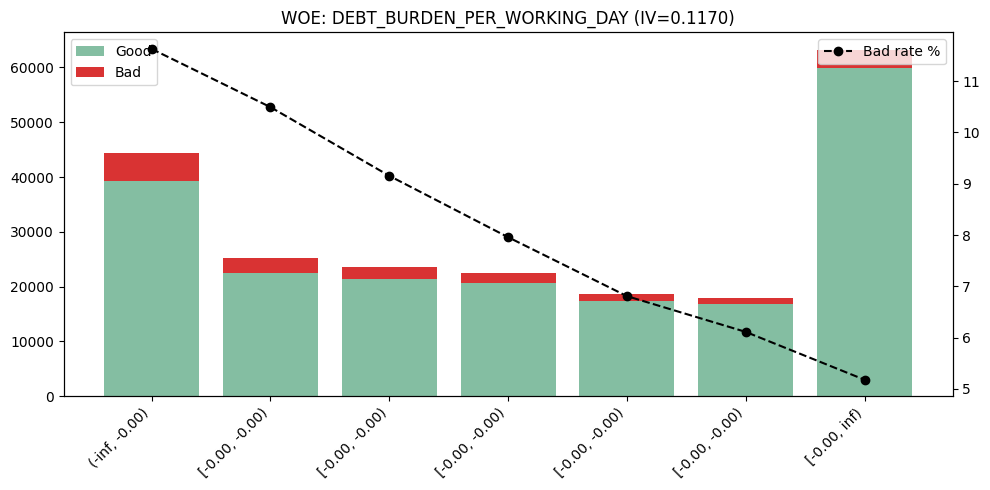

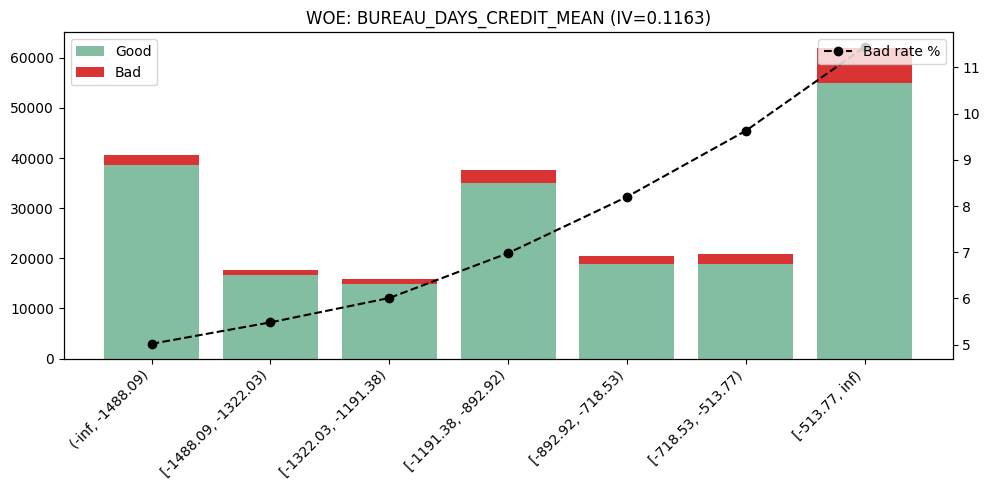

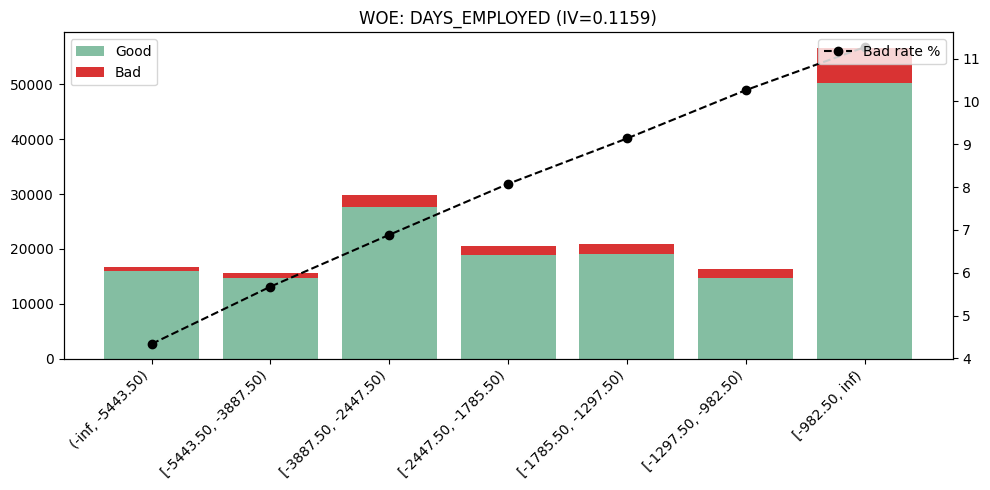

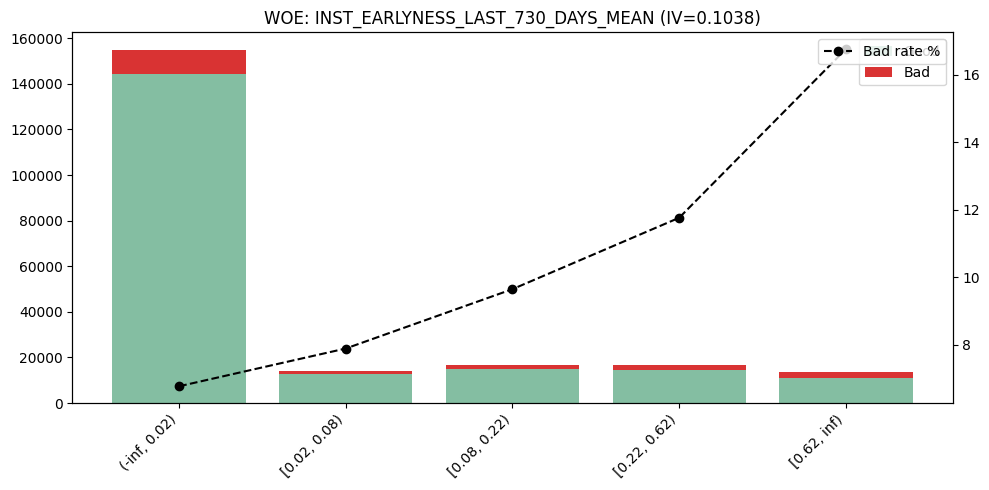

In [13]:
def plot_woe(feature, woe_df, iv):
    df_feat = woe_df[woe_df["Feature"] == feature].copy()
    if df_feat.empty:
        return
    mint, pink = "#66AE8B", "#D00000"
    fig, ax1 = plt.subplots(figsize=(10, 5))
    x_pos = np.arange(len(df_feat))
    ax1.bar(x_pos, df_feat["good"], color=mint, label="Good", alpha=.8)
    ax1.bar(x_pos, df_feat["bad"], bottom=df_feat["good"], color=pink, label="Bad", alpha=.8)
    ax1.set_xticks(x_pos)
    labels = df_feat["bin_range"].astype(str) if "bin_range" in df_feat.columns else df_feat["bin"].astype(str)
    ax1.set_xticklabels(labels, rotation=45, ha="right")
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.plot(x_pos, df_feat["bad_rate"] * 100, color="k", marker="o", ls="--", label="Bad rate %")
    ax2.legend(loc="upper right")
    plt.title(f"WOE: {feature} (IV={iv:.4f})")
    plt.tight_layout()
    plt.show()

for f in iv_df.head(10)["Feature"]:
    plot_woe(f, all_woe_df, iv_df.loc[iv_df["Feature"]==f, "IV"].values[0])

In [14]:
def psi_calculation(expected, actual, bins=10):
    expected, actual = np.asarray(expected), np.asarray(actual)
    expected, actual = expected[~np.isnan(expected)], actual[~np.isnan(actual)]
    if len(expected) == 0 or len(actual) == 0:
        return 0.0
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.quantile(expected, quantiles)
    cuts[0] -= 1e-6
    cuts[-1] += 1e-6
    exp_pct = np.histogram(expected, bins=cuts)[0] / (len(expected) + 1e-9)
    act_pct = np.histogram(actual, bins=cuts)[0] / (len(actual) + 1e-9)
    psi_vals = (act_pct - exp_pct) * np.log((act_pct + 1e-9) / (exp_pct + 1e-9))
    return float(psi_vals.sum())

psi_val = psi_calculation(dev_score, val_score)
psi_test = psi_calculation(dev_score, test_score)

print(f"PSI dev-val: {psi_val:.4f}")
print(f"PSI dev-test: {psi_test:.4f}")

PSI dev-val: 0.0002
PSI dev-test: 0.0049


In [15]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve,
    classification_report, f1_score
)

y_dev_pred_label = (dev_p >= 0.5).astype(int)
y_val_pred_label = (val_p >= 0.5).astype(int)

print("=== DEV ===")
print(classification_report(df_dev["TARGET"], y_dev_pred_label, digits=4))
print("F1-score DEV:", f1_score(df_dev["TARGET"], y_dev_pred_label))

print("=== VAL ===")
print(classification_report(df_val["TARGET"], y_val_pred_label, digits=4))
print("F1-score VAL:", f1_score(df_val["TARGET"], y_val_pred_label))

=== DEV ===
              precision    recall  f1-score   support

           0     0.9642    0.7038    0.8137    197880
           1     0.1723    0.7024    0.2768     17377

    accuracy                         0.7037    215257
   macro avg     0.5683    0.7031    0.5452    215257
weighted avg     0.9003    0.7037    0.7703    215257

F1-score DEV: 0.2767667834506843
=== VAL ===
              precision    recall  f1-score   support

           0     0.9636    0.7045    0.8139     84806
           1     0.1715    0.6967    0.2753      7448

    accuracy                         0.7038     92254
   macro avg     0.5675    0.7006    0.5446     92254
weighted avg     0.8996    0.7038    0.7704     92254

F1-score VAL: 0.2752712129651733


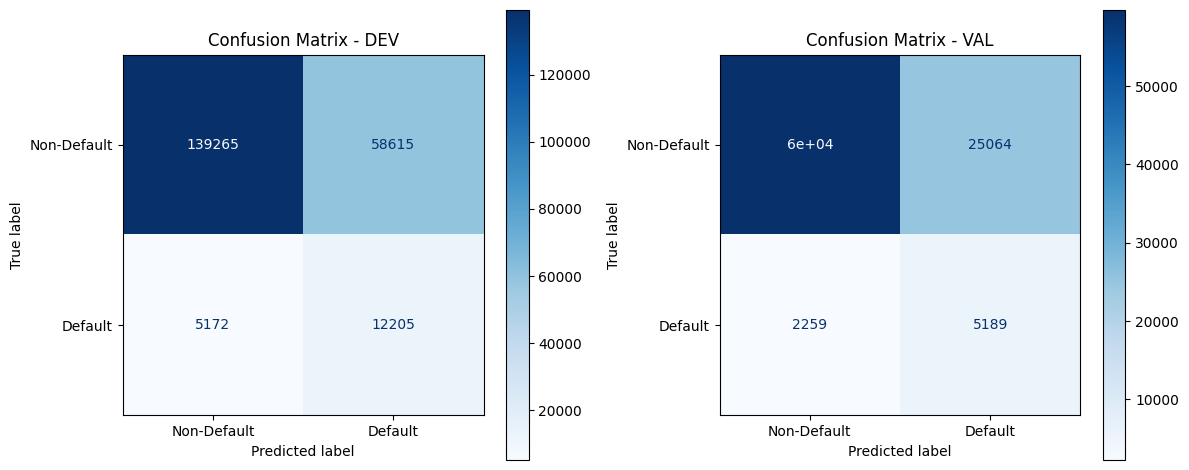

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# DEV
cm_dev = confusion_matrix(df_dev["TARGET"], y_dev_pred_label)
ConfusionMatrixDisplay(cm_dev, display_labels=["Non-Default", "Default"]).plot(ax=ax[0], cmap="Blues")
ax[0].set_title("Confusion Matrix - DEV")

# VAL
cm_val = confusion_matrix(df_val["TARGET"], y_val_pred_label)
ConfusionMatrixDisplay(cm_val, display_labels=["Non-Default", "Default"]).plot(ax=ax[1], cmap="Blues")
ax[1].set_title("Confusion Matrix - VAL")

plt.tight_layout()
plt.show()

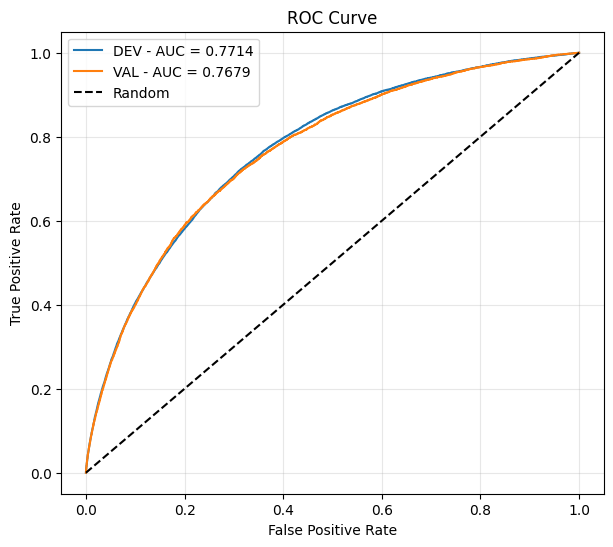

In [17]:
fpr_dev, tpr_dev, _ = roc_curve(df_dev["TARGET"], dev_p)
fpr_val, tpr_val, _ = roc_curve(df_val["TARGET"], val_p)

plt.figure(figsize=(7, 6))
plt.plot(fpr_dev, tpr_dev, label=f"DEV - AUC = {auc(fpr_dev, tpr_dev):.4f}")
plt.plot(fpr_val, tpr_val, label=f"VAL - AUC = {auc(fpr_val, tpr_val):.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [18]:
summary = pd.DataFrame({
    "Set": ["DEV", "VAL"],
    "AUC": [dev_auc, val_auc],
    "Gini": [dev_gini, val_gini],
    "KS": [dev_ks, val_ks],
    "F1": [f1_score(df_dev["TARGET"], y_dev_pred_label), f1_score(df_val["TARGET"], y_val_pred_label)],
    "PSI": [None, psi_val]
})

summary

,Set,AUC,Gini,KS,F1,PSI
0,DEV,0.771390,0.542779,0.408403,0.276767,NaN
1,VAL,0.767887,0.535773,0.403617,0.275271,0.000174
